In [19]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
movies = pd.read_csv('Data/movie_df.csv', encoding='utf8')
movies.head(20)

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/xBKGJQsAIeweesB79KC89FpBrVr.jpg,"[18, 80]",278,en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,28.527767,/9O7gLzmreU0nGkIB6K3BsJbzvNv.jpg,1994-09-23,The Shawshank Redemption,False,8.5,9773
1,False,/6xKCYgH16UuwEGAyroLU6p8HLIn.jpg,"[18, 80]",238,en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",36.965452,/rPdtLWNsZmAtoZl9PK7S2wE3qiS.jpg,1972-03-14,The Godfather,False,8.5,7394
2,False,/rIpSszng8P0DL0TimSzZbpfnvh1.jpg,"[18, 36, 10752]",424,en,Schindler's List,The true story of how businessman Oskar Schind...,19.945455,/yPisjyLweCl1tbgwgtzBCNCBle.jpg,1993-11-29,Schindler's List,False,8.4,5518
3,False,/gLbBRyS7MBrmVUNce91Hmx9vzqI.jpg,"[18, 80]",240,en,The Godfather: Part II,In the continuing saga of the Corleone crime f...,30.191804,/tHbMIIF51rguMNSastqoQwR0sBs.jpg,1974-12-20,The Godfather: Part II,False,8.4,4249
4,False,/xqjGKLwLZeujg4fiBTOqhZkoL31.jpg,"[18, 9648]",452522,en,Twin Peaks,Standalone version of the series pilot with an...,5.969249,/zQsEi6096L7PvowV39dtdqdW16f.jpg,1989-12-31,Twin Peaks,False,8.4,123
5,False,/6bbZ6XyvgfjhQwbplnUh1LSj1ky.jpg,[18],244786,en,Whiplash,"Under the direction of a ruthless instructor, ...",29.936676,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,2014-10-10,Whiplash,False,8.3,5544
6,False,/q7fXcrDPJcf6t3rzutaNwTzuKP1.jpg,"[12, 878, 28]",333339,en,Ready Player One,When the creator of a popular video game syste...,81.290391,/pU1ULUq8D3iRxl1fdX2lZIzdHuI.jpg,2018-03-28,Ready Player One,False,8.3,137
7,False,/mte63qJaVnoxkkXbHkdFujBnBgd.jpg,"[53, 80]",680,en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",39.232028,/dM2w364MScsjFf8pfMbaWUcWrR.jpg,1994-09-10,Pulp Fiction,False,8.3,10794
8,False,/cdlw13pUZxlN8h6WOcqO1UzJg1l.jpg,"[18, 878]",282848,en,Doctor Who: The Time of the Doctor,"Orbiting a quiet backwater planet, the massed ...",5.976601,/pEFGnBK6Kd4sqbkz7nMo3s4oyi2.jpg,2013-12-25,Doctor Who: The Time of the Doctor,False,8.3,112
9,False,/mMZRKb3NVo5ZeSPEIaNW9buLWQ0.jpg,[18],550,en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,42.100189,/adw6Lq9FiC9zjYEpOqfq03ituwp.jpg,1999-10-15,Fight Club,False,8.3,11878


In [8]:
movies.overview[6]

'When the creator of a popular video game system dies, a virtual contest is created to compete for his fortune.'

In [9]:
movies.describe()

,id,popularity,vote_average,vote_count
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,69250.750250,16.961788,7.534066,1835.930070
std,120417.652116,19.316284,0.288459,2497.068638
min,11.000000,1.340784,7.200000,100.000000
25%,872.000000,7.666765,7.300000,270.000000
50%,10400.000000,10.351264,7.500000,727.000000
75%,59436.000000,21.569239,7.700000,2287.000000
max,455661.000000,341.104188,8.500000,16669.000000


(array([330., 156., 123., 173.,  63.,  52.,  61.,  17.,  21.,   5.]),
 array([7.2 , 7.33, 7.46, 7.59, 7.72, 7.85, 7.98, 8.11, 8.24, 8.37, 8.5 ]),
 <a list of 10 Patch objects>)

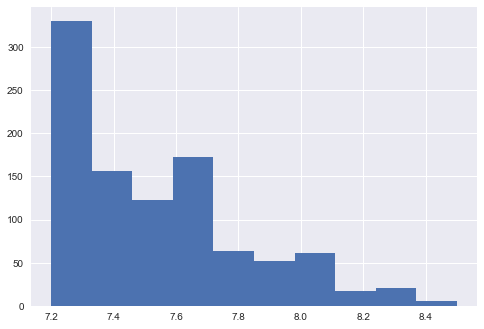

In [20]:
plt.hist(movies.vote_average)
plt.title('')

In [ ]:
type(movies.re)